### Bibliotek

In [237]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import os
import glob

%reload_ext autoreload
%autoreload 2
from src import *

[autoreload of src.noise failed: Traceback (most recent call last):
  File "C:\Users\skaug\AppData\Roaming\Python\Python312\site-packages\IPython\extensions\autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\skaug\AppData\Roaming\Python\Python312\site-packages\IPython\extensions\autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "c:\Users\skaug\AppData\Local\Programs\Python\Python312\Lib\importlib\__init__.py", line 131, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 866, in _exec
  File "<frozen importlib._bootstrap_external>", line 995, in exec_module
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "c:\GitHub\TTK4265-OptiskFjernmaaling\Prosjekt1\src\noise.py", line 5, in <module>
    from scipy.ndimage import mean_filter
ImportError: cannot import name 'mean_filter' from 'scipy.ndimage' (c:\Users\skaug\AppD

### Laste inn og gjennomsnittsberegne radiometriske kalibreringsbilder

In [238]:
#Data paths
notebook_dir = os.getcwd()

dark_paths_e50 = glob.glob(os.path.join(notebook_dir, 'Data', 'dark-images', 'E50', '*.bip'))  # Eksponering 50 ms
dark_paths_e100 = glob.glob(os.path.join(notebook_dir, 'Data', 'dark-images', 'E100', '*.bip'))  # Eksponering 100 ms
dark_paths_e300 = glob.glob(os.path.join(notebook_dir, 'Data', 'dark-images', 'E300', '*.bip'))  # Eksponering 300 ms
dark_paths_e450 = glob.glob(os.path.join(notebook_dir, 'Data', 'dark-images', 'E450', '*.bip'))  # Eksponering 450 ms
dark_paths_e500 = glob.glob(os.path.join(notebook_dir, 'Data', 'dark-images', 'E500', '*.bip'))  # Eksponering 500 ms
dark_paths_e1000 = glob.glob(os.path.join(notebook_dir, 'Data', 'dark-images', 'E1000', '*.bip'))  # Eksponering 1000 ms

B_measured_200W_E100_paths = glob.glob(os.path.join(notebook_dir, 'Data', 'MeasuredIntensity', '200W', 'E100', '*.bip'))  # 200W, Eksponering 100 ms
B_measured_200W_E500_paths = glob.glob(os.path.join(notebook_dir, 'Data', 'MeasuredIntensity', '200W', 'E500', '*.bip'))  # 200W, Eksponering 500 ms
B_measured_200W_E1000_paths = glob.glob(os.path.join(notebook_dir, 'Data', 'MeasuredIntensity', '200W', 'E1000', '*.bip'))  # 200W, Eksponering 1000 ms

B_measured_1000W_E100_paths = glob.glob(os.path.join(notebook_dir, 'Data', 'MeasuredIntensity', '1000W', 'E100', '*.bip'))  # 1000W, Eksponering 100 ms
B_measured_1000W_E300_paths = glob.glob(os.path.join(notebook_dir, 'Data', 'MeasuredIntensity', '1000W', 'E300', '*.bip'))  # 1000W, Eksponering 300 ms
B_measured_1000W_E450_paths = glob.glob(os.path.join(notebook_dir, 'Data', 'MeasuredIntensity', '1000W', 'E450', '*.bip'))  # 1000W, Eksponering 450 ms

## Calculate average images for each dataset and save them as .txt files (this is done only once)
#calculate_average_image(B_measured_200W_E100_paths, 'Data/Average/MeasuredData/B_200W_E100_avg.txt', PixelWidth, PixelHeight)
#calculate_average_image(B_measured_200W_E500_paths, 'Data/Average/MeasuredData/B_200W_E500_avg.txt', PixelWidth, PixelHeight)
#calculate_average_image(B_measured_200W_E1000_paths, 'Data/Average/MeasuredData/B_200W_E1000_avg.txt', PixelWidth, PixelHeight)

#calculate_average_image(dark_paths_e50, 'Data/Average/Noise/Dark_Image_E50_avg.txt', PixelWidth, PixelHeight)
#calculate_average_image(dark_paths_e100, 'Data/Average/Noise/Dark_Image_E100_avg.txt', PixelWidth, PixelHeight)
#calculate_average_image(dark_paths_e300, 'Data/Average/Noise/Dark_Image_E300_avg.txt', PixelWidth, PixelHeight)
#calculate_average_image(dark_paths_e450, 'Data/Average/Noise/Dark_Image_E450_avg.txt', PixelWidth, PixelHeight)
#calculate_average_image(dark_paths_e500, 'Data/Average/Noise/Dark_Image_E500_avg.txt', PixelWidth, PixelHeight)
#calculate_average_image(dark_paths_e1000, 'Data/Average/Noise/Dark_Image_E1000_avg.txt', PixelWidth, PixelHeight)

### Støy

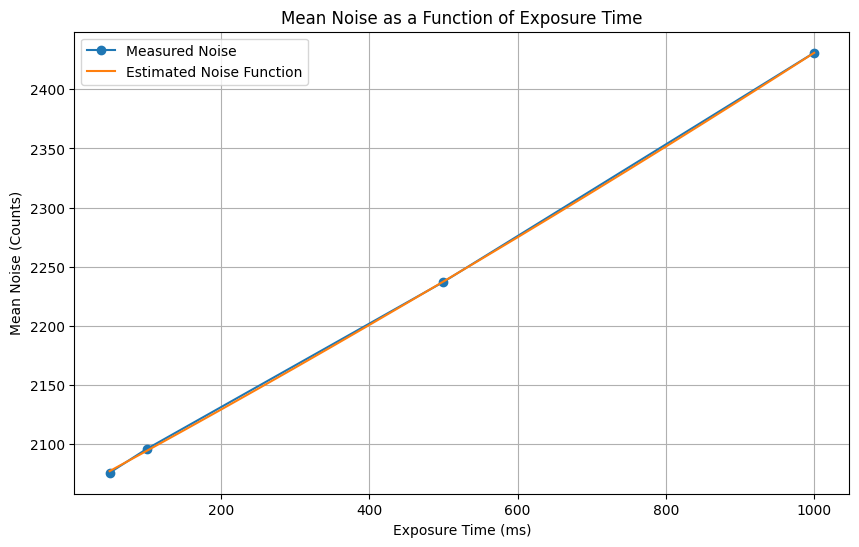

In [239]:
# Directory containing the dark images
directory = 'Data/Average/Noise/'

# Initialize lists to store exposure times and noise values
exposure_times = []
noise_values = []

# List all .txt files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.txt'):
        # Extract the exposure time from the filename
        # Example filename: Dark_Image_E100_avg.txt
        exposure_time_str = filename.split('_')[2].replace('E', '').replace('avg.txt', '')
        exposure_time = int(exposure_time_str)
        exposure_times.append(exposure_time)
        
        # Read the image data from the file
        file_path = os.path.join(directory, filename)
        image_data = np.loadtxt(file_path, delimiter=',')
        
        # Calculate the mean noise (mean pixel value)
        mean_noise = np.mean(image_data)
        noise_values.append(mean_noise)

# Convert lists to numpy arrays for plotting
exposure_times = np.array(exposure_times)
noise_values = np.array(noise_values)

# Sort the data by exposure times
sorted_indices = np.argsort(exposure_times)
exposure_times = exposure_times[sorted_indices]
noise_values = noise_values[sorted_indices]

#estimate the mean noise as a function of exposure time
exp_times = np.arange(50, 1001, 50)

# Plot the noise as a function of exposure time
plt.figure(figsize=(10, 6))
plt.plot(exposure_times, noise_values, marker='o', label='Measured Noise')
plt.plot(exp_times, noise.get_expected_mean_noise(exp_times), label='Estimated Noise Function')
plt.xlabel('Exposure Time (ms)')
plt.ylabel('Mean Noise (Counts)')
plt.title('Mean Noise as a Function of Exposure Time')
plt.legend()
plt.grid(True)
plt.show()

### Tihi 2

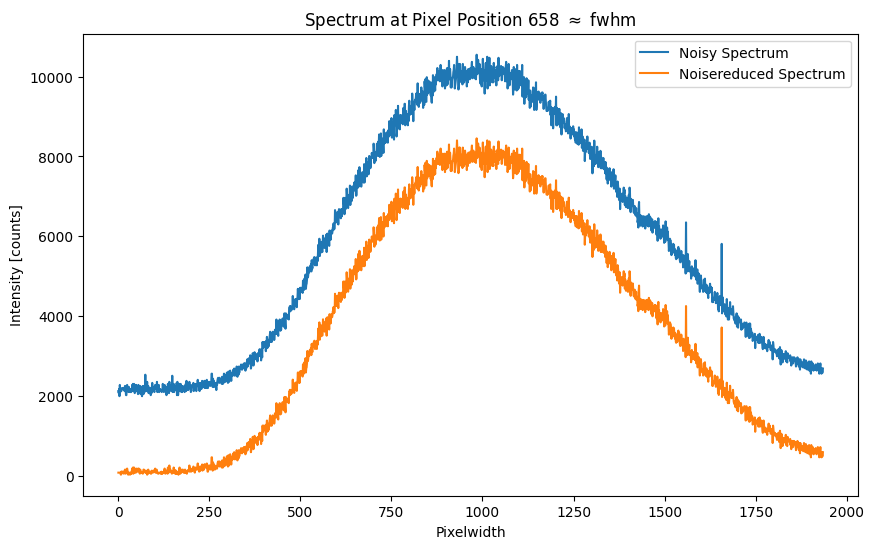

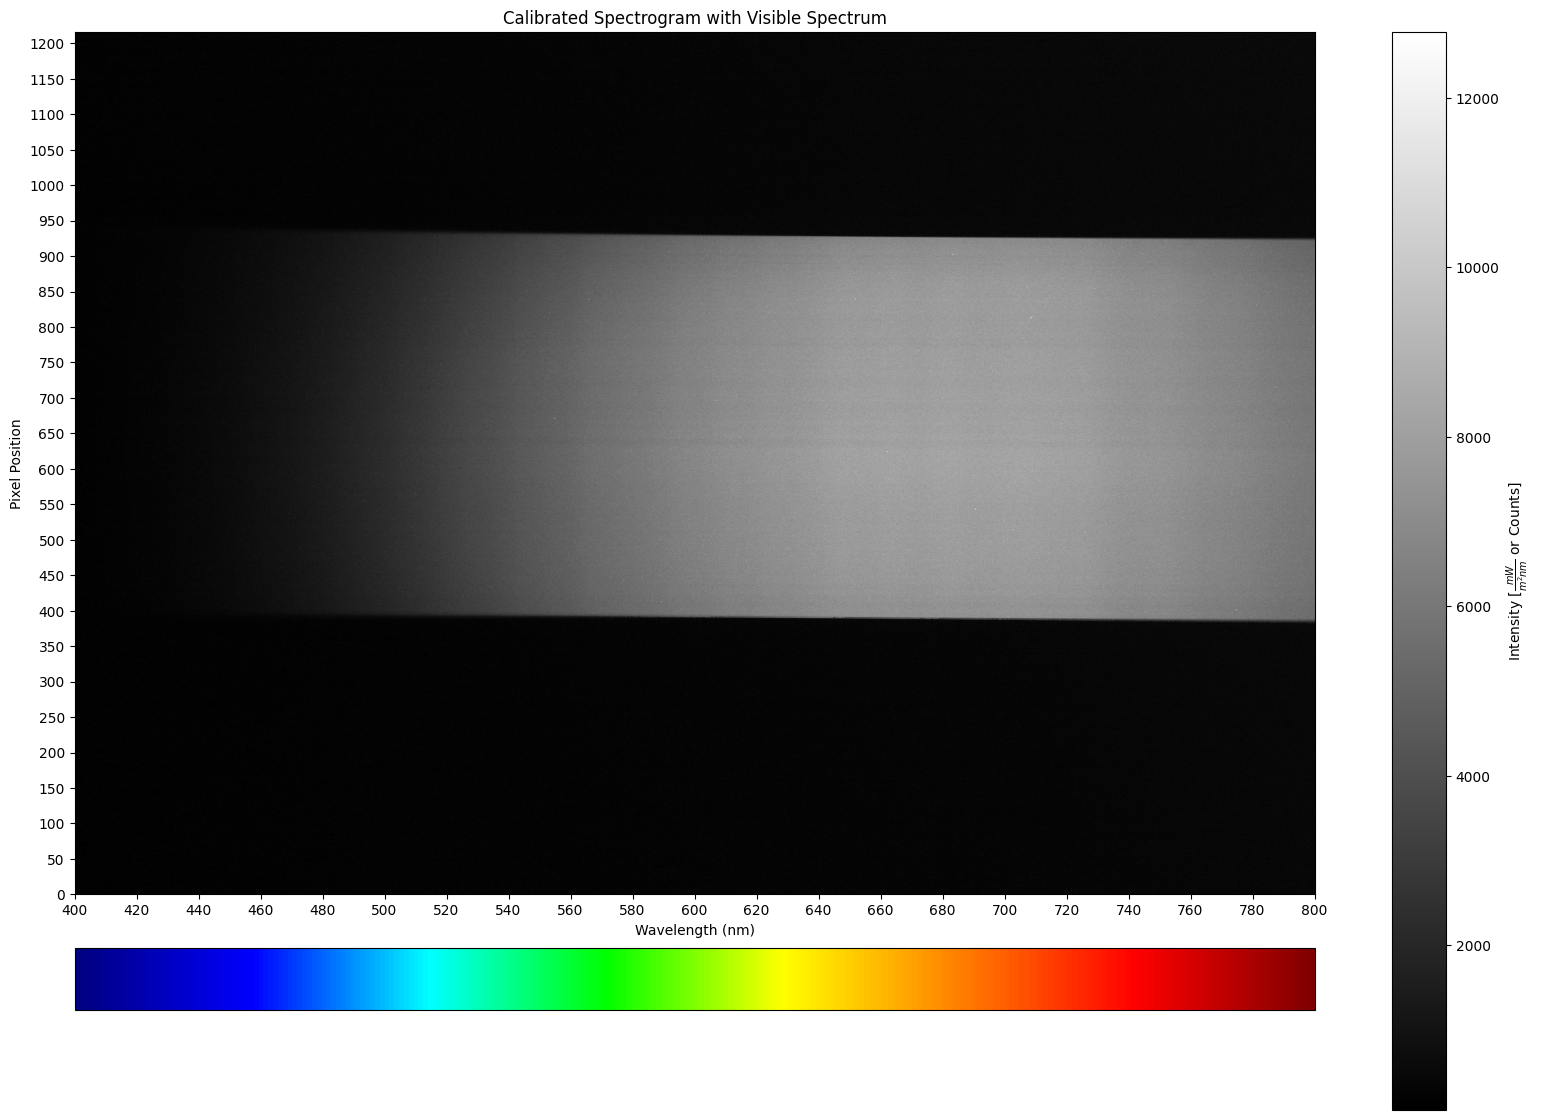

In [240]:
# Measured data
B = np.loadtxt('Data/Average/MeasuredData/B_200W_E100_avg.txt', delimiter=',')
exposure_time = 100

B_Noiseless = noise.remove_noise(B, exposure_time) # Removes expected noise from the image depending on exposure time 

PixMid = 1216//2 + 50 

plt.figure(figsize=(10, 6))
plt.plot(B[PixMid,:], label='Noisy Spectrum')
plt.plot(B_Noiseless[PixMid,:], label='Noisereduced Spectrum')
plt.xlabel("Pixelwidth")
plt.ylabel('Intensity [counts]')
plt.title(rf'Spectrum at Pixel Position {PixMid} $\approx$ fwhm')
plt.legend()
plt.show()


spec, wave = calibration.pix_to_wavelength(B_Noiseless) # Convert pixel values to wavelength values

visualization.plot_visible_spectrum_cmap(spec, wave)

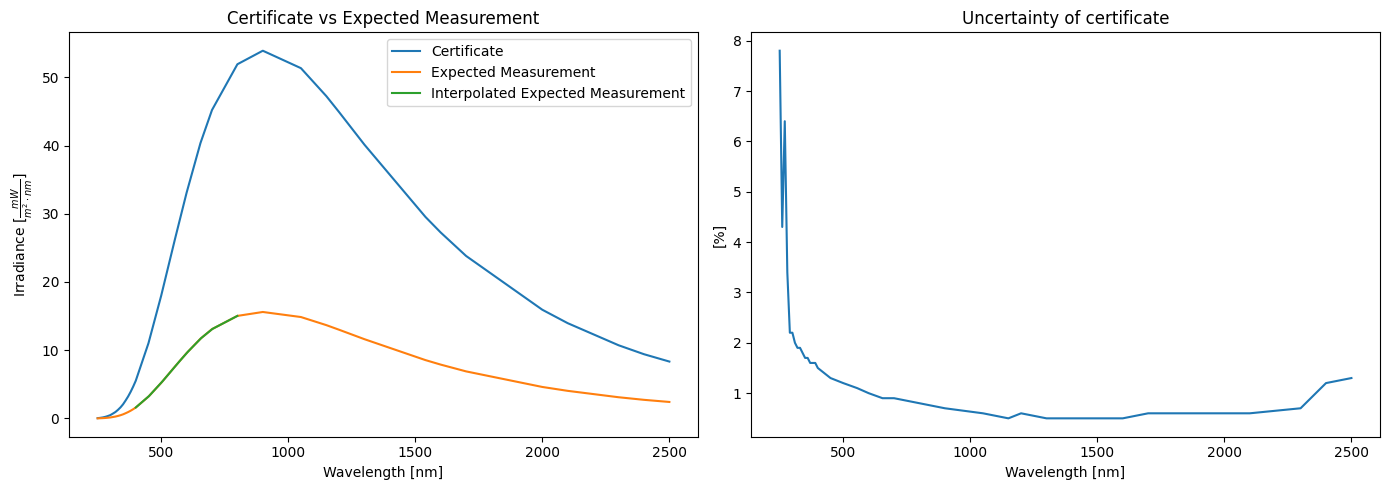

In [241]:
#Certificate data
W_L = np.loadtxt('Data/Calibrated/calibrationCertificate200W.txt', usecols=0) # Wavelengths in nm
B_0 = np.loadtxt('Data/Calibrated/calibrationCertificate200W.txt', usecols=1) # Irradiance in mW/m^2/nm
sigma = np.loadtxt('Data/Calibrated/calibrationCertificate200W.txt', usecols=2) # Uncertainty in %

# Interpolate the expected irradiance values to the same wavelengths as the measured data
B_expected, W_L = calibration.expected_irradiance()
B_interpolated = calibration.expected_irradiance(wave)

fig, (ax1, ax2) = plt.subplots(1,2 ,figsize=(14, 5))

# First subplot
ax1.plot(W_L, B_0, label='Certificate')
ax1.plot(W_L, B_expected, label='Expected Measurement')
ax1.plot(wave, B_interpolated, label='Interpolated Expected Measurement')
ax1.set_xlabel('Wavelength [nm]')
ax1.set_ylabel(r'Irradiance [$\frac{mW}{m^2\cdot nm}$]')
ax1.legend()
ax1.set_title('Certificate vs Expected Measurement')

# Second subplot
ax2.plot(W_L, sigma)
ax2.set_xlabel('Wavelength [nm]')
ax2.set_ylabel('[%]')
ax2.set_title('Uncertainty of certificate')

# Adjust layout
plt.tight_layout()
plt.show()


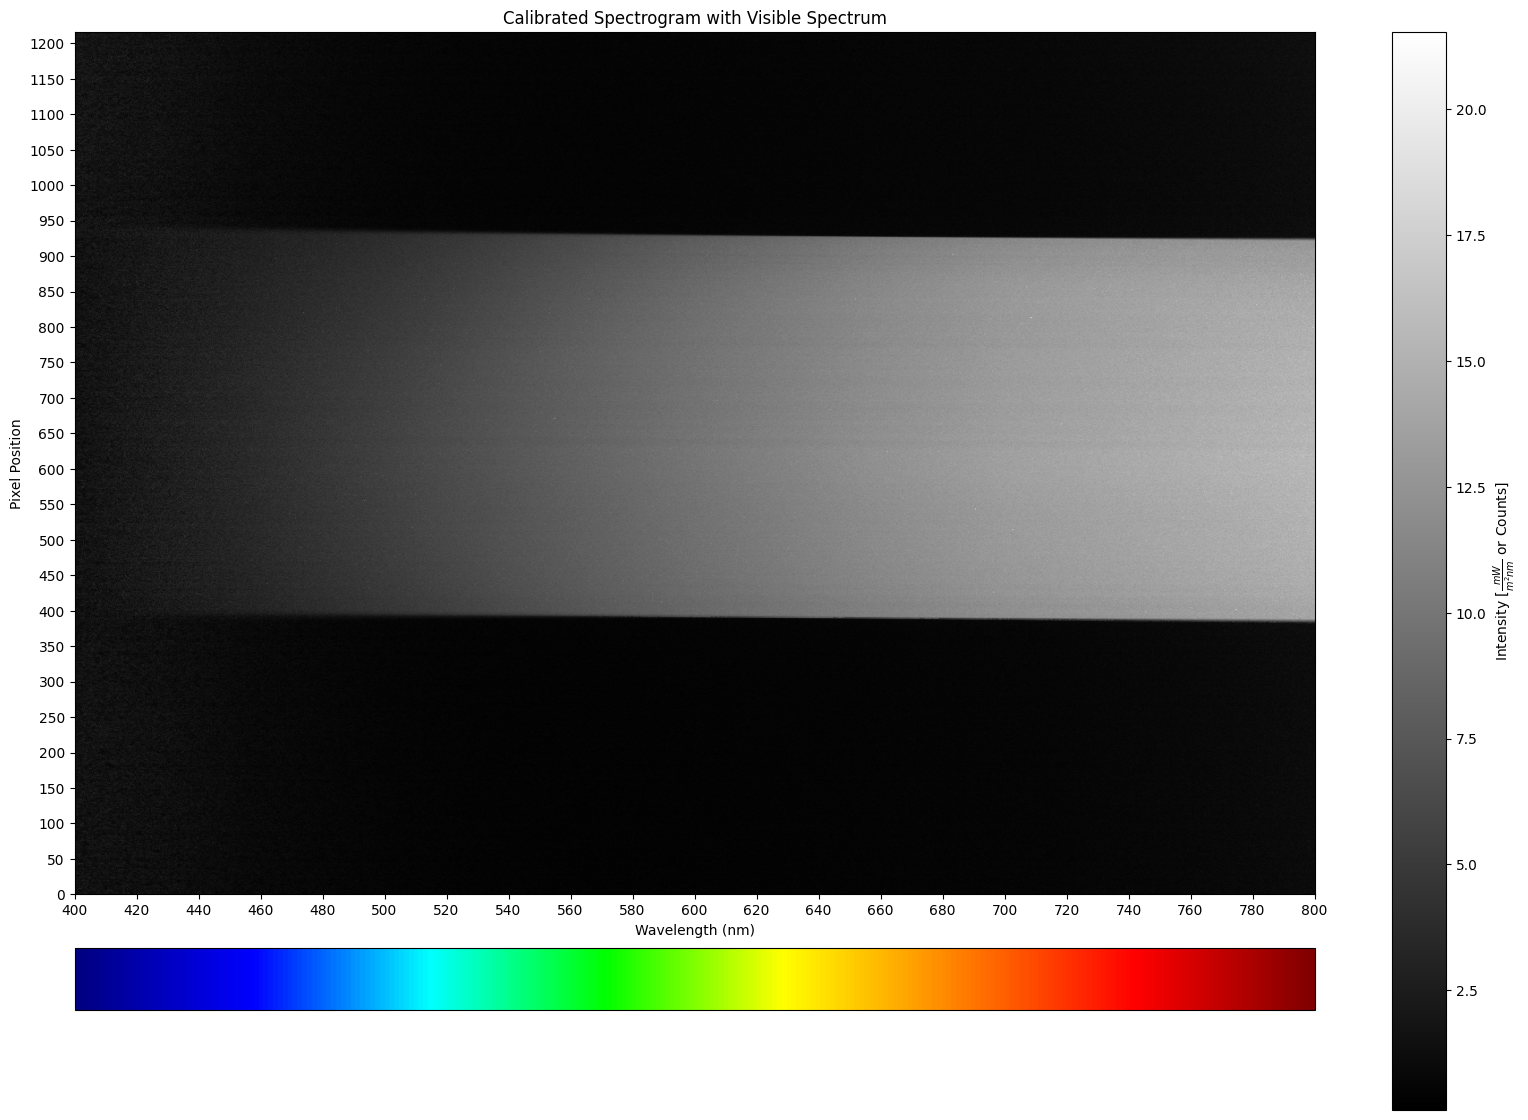

In [242]:
# Normalize the measured spectrum to the expected irradiance values at 1 ms exposure time 
spec_norm = spec / exposure_time

# Slice the array to get the desired range of rows
spec_slice = spec_norm[346:766, :]

# Calculate the mean of each row within the specified range
row_means = np.mean(spec_slice, axis=0)

# Calculate scaling factor to transform counts to mW/m^2/nm and save to file
scaling_factor = B_interpolated / row_means
scaling_factor[np.isinf(scaling_factor)] = 0

np.savetxt('Data/Calibrated/Scaling_Factor.txt', scaling_factor, delimiter=',')

visualization.plot_visible_spectrum_cmap(scaling_factor*spec_norm, wave)

### Test

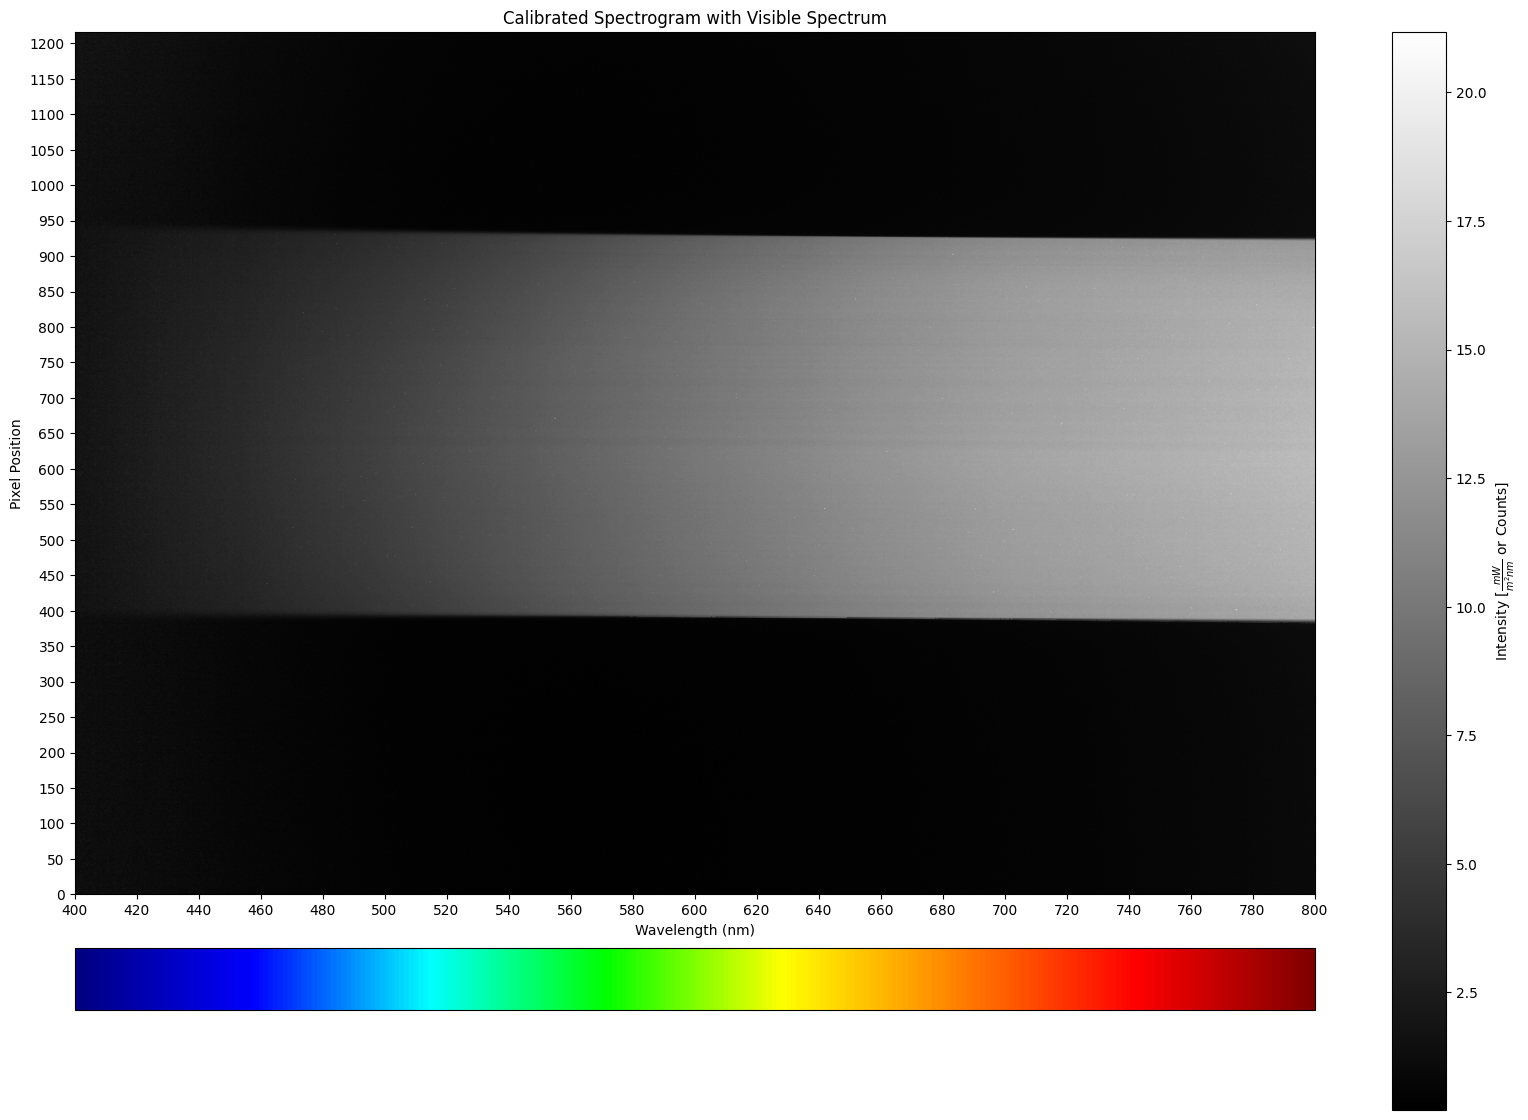

In [243]:
im = np.loadtxt('Data/Average/MeasuredData/B_200W_E500_avg.txt', delimiter=',')
exposure_time = 500

testSpec, testWave = calibration.full_calibration(im, exposure_time)

visualization.plot_visible_spectrum_cmap(testSpec, testWave)

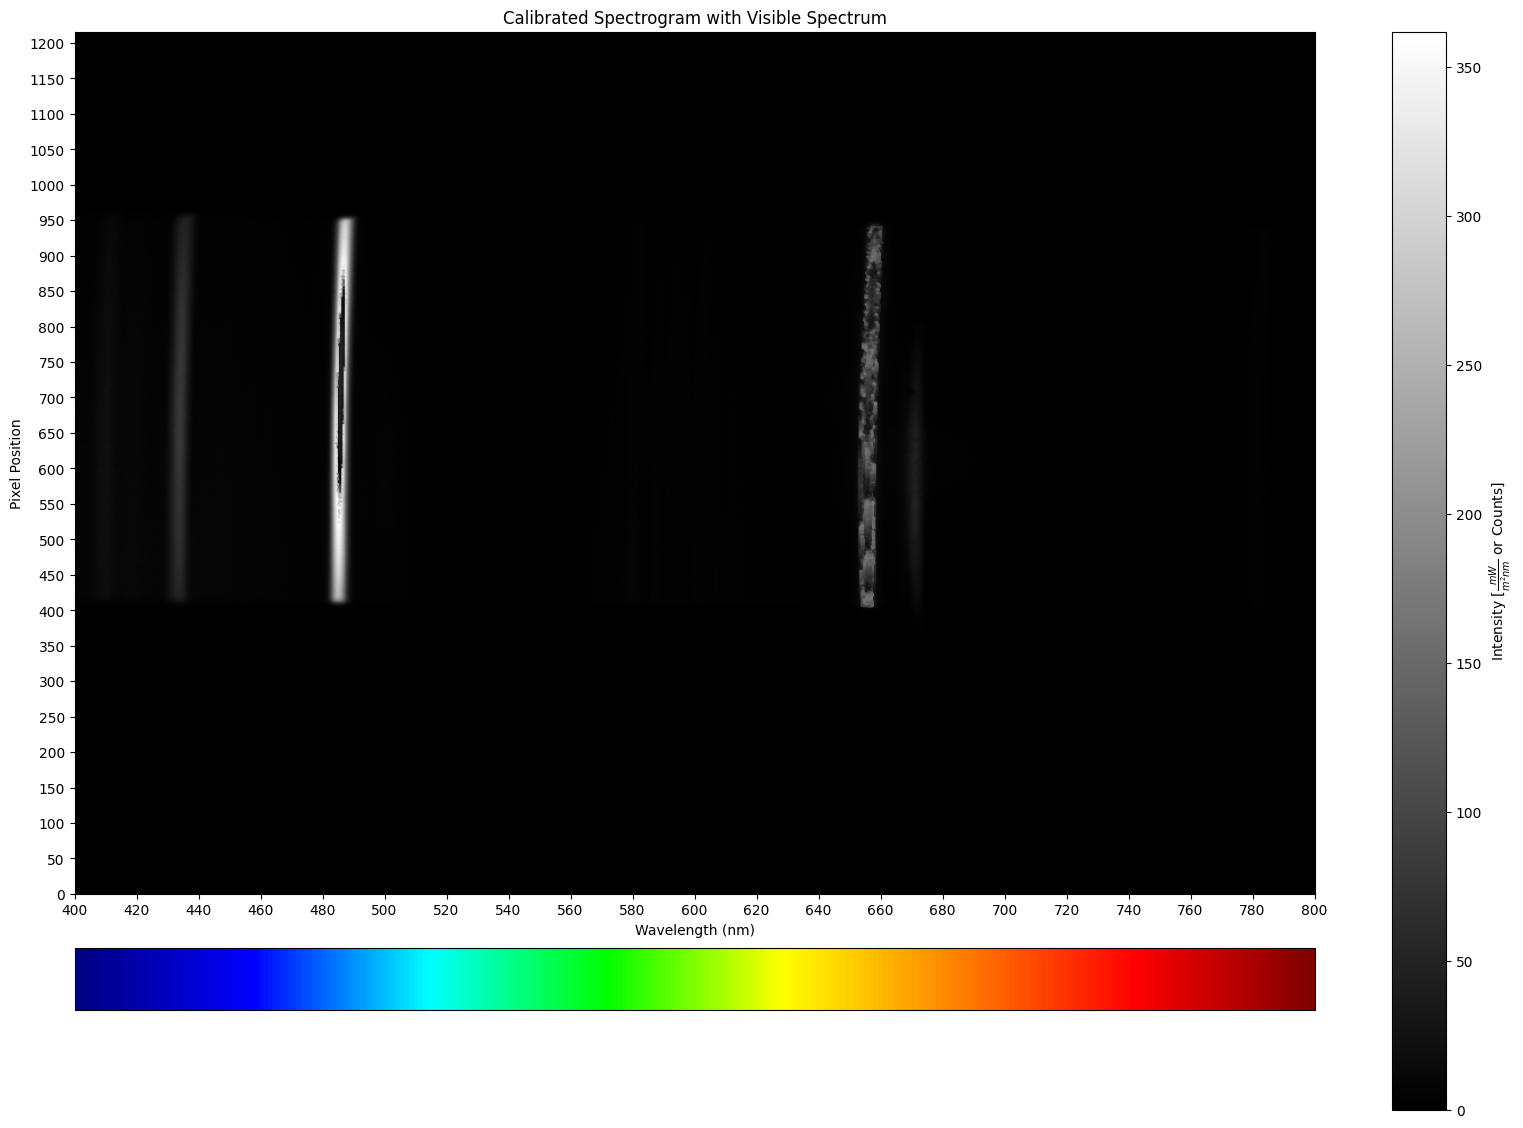

In [244]:
Gass = np.loadtxt('Data/Average/H_avg.txt', delimiter=',') # H exposure time = 50 ms, He exposure time = 30 ms, Hg exposure time = 100 ms
Gass_exposure = 50

GassSpec, GassWave = calibration.full_calibration(Gass, Gass_exposure)

visualization.plot_visible_spectrum_cmap(GassSpec, GassWave)